# Black-Scholes-Merton model
#### Roland Grinis - MIPT & GrinisRIT
#### Ivan Novikov - MIPT
#### Evgeny Filipov - MIPT

In [1]:
import torch
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

## 1 Black-Scholes Formulae

### 1.1 Forward dynamics with constant volatility
This model describes the evolution the forward $f_t$ via GBM dynamics:

$$
\text{d}f_t = \mu f_t\text{d}t + \sigma f_t \text{d}W_t
$$

The volatility $\sigma$ is called the *implied volatility* and is provided by market participants. Being constant is a severe limitation for practitioners, but we will address this issue with stochastic volatility models later.

Calibrating the drift $\mu$ is not possible without apriori information which fundamentally depends on each investors view on the market. 

The igenious idea was to note that the choice of $\mu$ is linked to the choice of probability measure $\mathbb{P}$.

### 1.2 Existence of Risk-Neutral Measure

In the BSM model, substituting:
$$
\gamma = \frac{\mu}{\sigma}
$$
into Girsanov's result leads to martingale dynamics for the forward:
$$
\text{d}f_t = \sigma f_t \text{d}W^\gamma_t
$$
under $\mathbb{Q}^\gamma$. To avoid arbitrage, the forward values of all derivative contracts must also be martingales under that measure. 

As a special case, assuming constant instantaneous spot interest rate $r>0$ and having the zero-coupon bond as numéraire:
$$
f_t = e^{r(T-t)}S_t
$$

we can derive the Black-Scholes model for the underlying:
$$
\text{d}S_t = r S_t\text{d}t + \sigma S_t \text{d}W^\gamma_t
$$

which is not a martingale anymore.

Does the valuation we obtained in the risk neutral world is the fair price for the actual measure $\mathcal{P}$?

### 1.3 Black-Scholes PDE

Let's start again from the BSM model. Considering European contracts for simplicity, the  Feynman-Kac formula for the risk-neutral dynamics gives:
$$
\frac{\partial FV}{\partial t} + \frac{1}{2}\sigma^2 f_t^2 \frac{\partial^2 FV}{\partial t^2}=0
$$

This is also known as the *Black-Scholes PDE*.

### 1.4 Replication

By Ito and the above, under the measure $\mathbb{P}$, the derivative's $FV_t$ evolves as:
$$
\begin{split}
\text{d}FV_t & = \left(\frac{\partial FV}{\partial t}+ \mu f_t \frac{\partial FV}{\partial f_t} + \frac{1}{2}\sigma^2 f_t^2 \frac{\partial^2 FV}{\partial t^2} \right)\text{d}t + \sigma f_t\frac{\partial FV}{\partial f_t} dW_t \\
 & =  \mu f_t \frac{\partial FV}{\partial f_t}\text{d}t   + \sigma f_t\frac{\partial FV}{\partial f_t} dW_t \\
 & = \frac{\partial FV}{\partial f_t} df_t
\end{split}
$$

and so we can exactly replicate the derivative by trading in the forward on the underlying as dictated by $\partial FV / \partial f_t$ - the so called *delta*. 

By no-arbitrage principle, we conclude that the risk neutral price is fair for *any* measure $\mathbb{P}$ within the framework of the BSM model.

### 1.6 Analytic formulae

Under the BSM model:
$$
\frac{\text{d}f_t}{f_t} = \sigma \text{d}W_t
$$

The forward value of a European Call at strike $K$ and maturity date $T$ is given by:
$$
FV_C = f_t \text{N}(d_{+}) - K \text{N}(d_{-})
$$

where $N(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is the standard normal CDF and:
$$
d_{\pm} = \frac{\log \frac{f_t}{K} \pm \frac{1}{2}\sigma^2(T-t) }{\sigma \sqrt{T-t}  } 
$$


For the European Put, one can rely on the put-call parity $FV_C - FV_P = f_t - K$:
$$
FV_P = -f_t \text{N}(-d_{+}) + K \text{N}(- d_{-})
$$

#### 1.6.1 Greeks

There are three main risk sensitivies:
* *Delta* $\Delta$ measures the exposure to the underlying:
$$
\begin{split}
 \Delta & \equiv \frac{\partial FV_C}{\partial f} = \text{N}(d_{+})   \\
 \Delta & \equiv \frac{\partial FV_P}{\partial f} = - \text{N}(-d_{+}) = \text{N}(d_{+}) - 1
\end{split}
$$

* *Vega* (also often called *Kappa*) is the exposure to volatility:
$$
\mathcal{V} \equiv \frac{\partial FV_C}{\partial \sigma} = \frac{\partial FV_P}{\partial \sigma} = \text{N}'(d_{+}) f_t \sqrt{T-t}
$$
* *Curvature* is supposed to measure the convexity:
$$
\Upsilon \equiv \frac{\sigma}{\left(f_t\sigma \sqrt{T-t}\right)^2} \mathcal{V} = \frac{\text{N}'(d_{+})}{f_t\sigma \sqrt{T-t}}
$$

The definition of curvature above is somewhat of an abuse of terminology as we should have been capturing second order information with *Gamma*:
$$
\Gamma \equiv \frac{\partial^2 FV_C}{\partial f^2} = \frac{\partial^2 FV_P}{\partial f^2} = \frac{\text{N}'(d_{+})}{f_t\sigma \sqrt{T-t}}
$$

But higher order derivatives are expensive to compute. And as we can easily see, in the special case of BSM this is justified via what is known the *Gamma-Vega relation*.

Finally, another quantity of interest is *Theta* - the decay of the value of optionality over time:
$$
 \Theta \equiv \frac{\partial FV_C}{\partial t}= \frac{\partial FV_P}{\partial t} = - \frac{\sigma f_t \text{N}'(d_{+})}{2 \sqrt{T-t}}  
$$

In [2]:
normal = torch.distributions.Normal(0,1)
N = normal.cdf
logNp = normal.log_prob

In [3]:
def BS_call_FV(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    d2 = d1 - sigma*torch.sqrt(dt)
    return forward*N(d1) - strike*N(d2)

In [4]:
def BS_call_Delta(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return N(d1)

In [7]:
def BS_call_Vega(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return torch.exp(logNp(d1)) * forward * torch.sqrt(dt)

In [8]:
def BS_call_Gamma(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return torch.exp(logNp(d1)) / (forward * sigma * torch.sqrt(dt))

In [9]:
def BS_call_Theta(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return - forward * sigma * torch.exp(logNp(d1)) / (2 * torch.sqrt(dt))

In [10]:
forward, time_t = torch.meshgrid(
    torch.linspace(50, 150, steps=500), 
    torch.linspace(0, 1, steps=500)[:-1], indexing='xy')
strike = torch.tensor([100.])
maturity = torch.tensor([1.])
sigma = 0.3

In [11]:
FV = BS_call_FV(forward, time_t, strike, maturity, sigma)
Delta = BS_call_Delta(forward, time_t, strike, maturity, sigma)
Vega = BS_call_Vega(forward, time_t, strike, maturity, sigma)
Curvature = BS_call_Gamma(forward, time_t, strike, maturity, sigma)
Theta = BS_call_Theta(forward, time_t, strike, maturity, sigma)

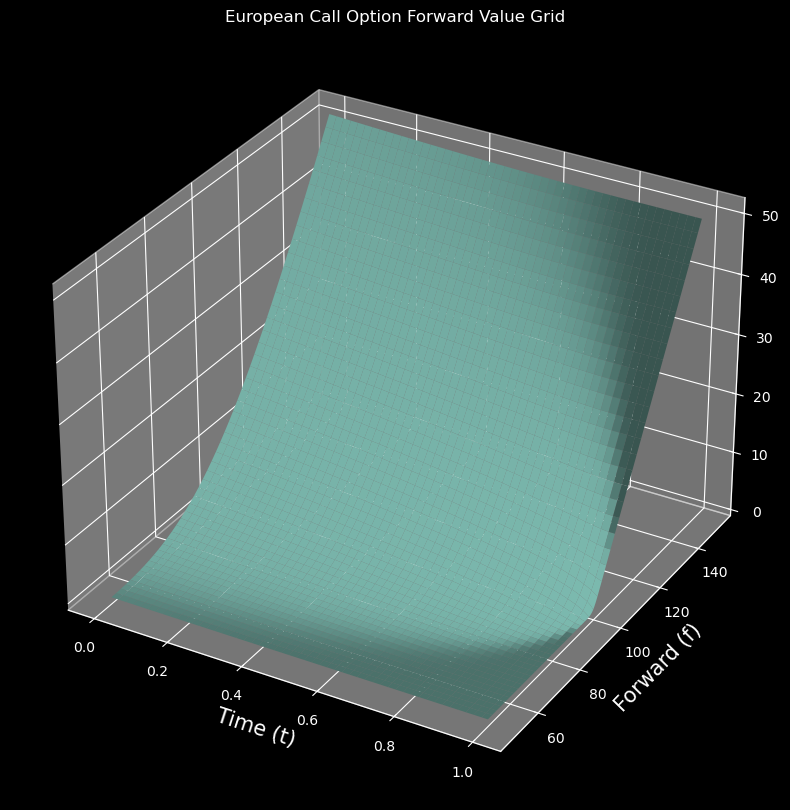

In [15]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), FV.numpy())
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Forward Value Grid')
plt.grid(True)
plt.show()

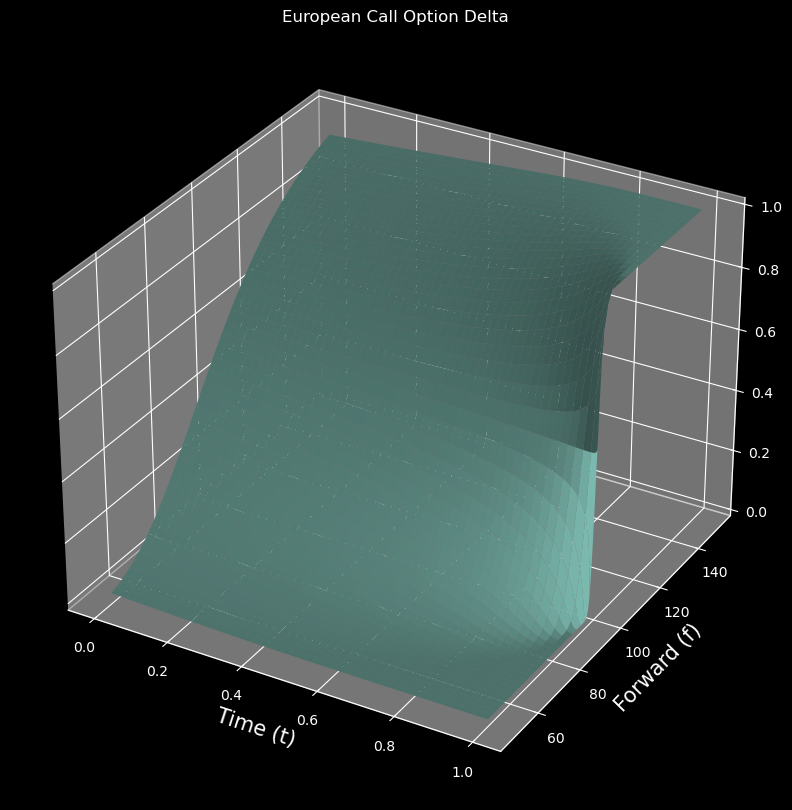

In [16]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Delta.numpy())
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Delta')
plt.show()

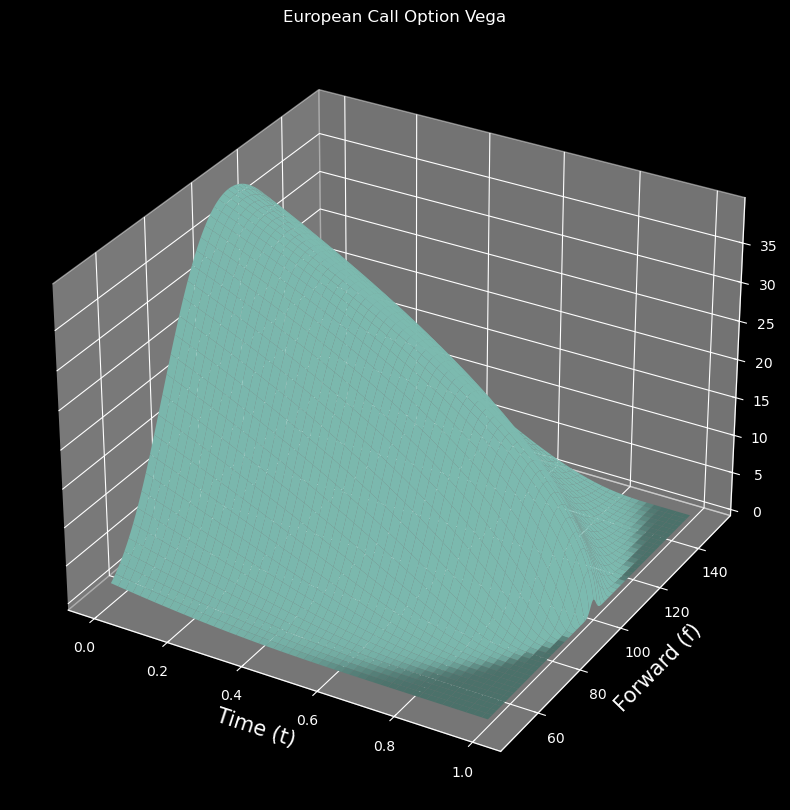

In [17]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Vega.numpy())
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Vega')
plt.show()

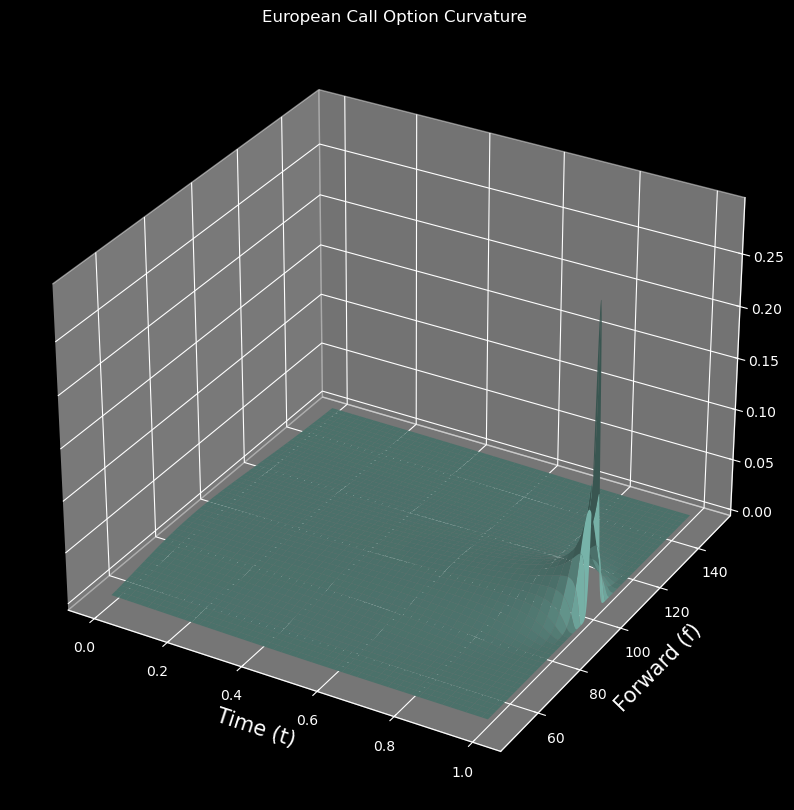

In [18]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Curvature.numpy())
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Curvature')
plt.show()

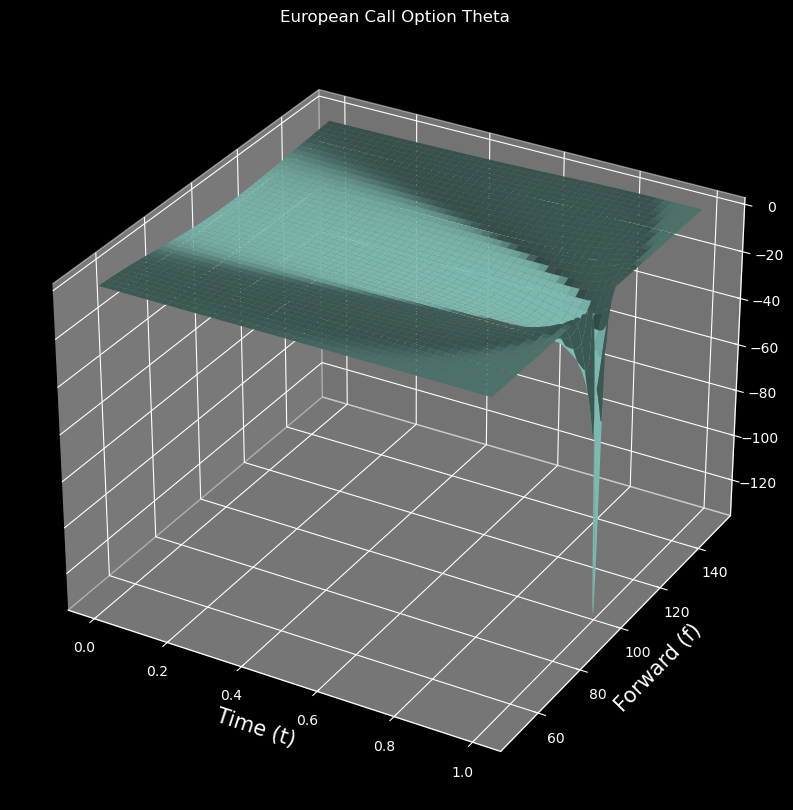

In [19]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Theta.numpy())
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Theta')
plt.show()

#### Exercise 1.6.2: Put Delta
Implement and plot the delta for the Put.

## 2 The Binomial Method
Consider a discrete model for a stock price $S_0, S_{t_1}, \dots, S_{t_M}$ with $t_{i+1} = t_i + \Delta t$ and:

\begin{equation*} 
\begin{split}
\mathbb{P} \left(S_{t_{i+1}} = u S_{t_i} \right) & = p \\
\mathbb{P} \left(S_{t_{i+1}} = d S_{t_i} \right) & = 1 - p
\end{split}
\end{equation*}
for constants  $0 <d < u$ such that $u \cdot d=1$ and a probability $0 < p < 1$. We assume a constant continuously compounded interest rate $r > 0$ and the zero-coupon as numéraire.

### 2.1 Approximating the Black-Scholes SDE
Setting:
\begin{equation*} 
\begin{split}
p & = \frac{e^{r\Delta t} - d}{u - d} \\
u & = \beta + \sqrt{\beta^2 -1}
\end{split}
\end{equation*}

where: 
$$
\beta = \frac{1}{2}\left(e^{-r\Delta t} + e^{(r+\sigma^2)\Delta t}\right)
$$

we obtain a discretisation for:
$$
\text{d}S_t = r S_t\text{d}t + \sigma S_t \text{d}W_t
$$

with linear weak convergence $O(\Delta t)$.


### 2.2 European options

#### 2.2.1 Pricing algorithm
Let's start with $t_0 = 0$ and assume a maturity $t_M = 1$, we get $\Delta t = \frac1{M}$. Let us denote:
$$
S_{j,i} = S_0 u^j d^{i - j} = S_0 u^{2j - i}
$$ 
where $i$ corresponds to time $t_i$ and $j$ is a number of time periods before $t_i$ when price goes up.

According to risk neutral dynamics for European option price
$$
    V_{j,i} = e^{-r \Delta t} (p V_{j + 1,i + 1} + (1 - p) V_{j,i + 1})
$$

For the next step $i + 2$ we get:
\begin{equation*} 
\begin{split}
V_{j,i} & = e^{-r \Delta t} (p V_{j + 1,i + 1} + (1 - p) V_{j,i + 1}) \\
        & = e^{-2r \Delta t} (p(p V_{j + 2,i + 2} + (1 - p) V_{j + 1,i + 2}) + (1 - p)(p V_{j + 1,i + 2} + (1 - p) V_{j,i + 2})) \\
        & = e^{-2r \Delta t} (p^2 V_{j + 2,i + 2} + 2p(1 - p) V_{j + 1,i + 2} + (1 - p)^2 V_{j,i + 2})
\end{split}
\end{equation*}
In general this gives:
$$
V_{j,i} = e^{-rM \Delta t} \sum \limits_{k = 0}^{M} C_M^k p^k (1 - p)^{M - k} V_{j + k,i + M}
$$
For our case $i = 0$, $j = 0$ at $t_0 = 0$ and $\Delta t = \frac1{M}$ we obtain:
\begin{equation}
    V_{0,0} = e^{-r} \sum \limits_{k = 0}^{M} C_M^k p^k (1 - p)^{M - k} V_{k,M} = e^{-r} \sum \limits_{j = 0}^{M} C_M^j p^j (1 - p)^{M - j} V_{j,M}
\end{equation}
where $V_{j,M} = (S_{j, M} - K)^{+}$ is the call option payoff at maturity, and $V_{j,M} = (K - S_{j, M})^{+}$ if we want the put.

In [12]:
M = 100
S_0 = 50
K = 70
u = 1.05
d = 1 / u
r = 0.01

@nb.njit()
def get_proba(r, u, d, M):
    return (np.exp(r / M) - d) / (u - d)

p = get_proba(r, u, d, M)
print(p)

0.48882931951390296


In [8]:
# return the price of a call option at maturity t_M = 1 where j is number of upward moves
@nb.njit()
def price_mature_call(S_0, K, u, d, M):
    S_M = np.zeros(M + 1)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(S_M - K, 0)

mature_layer = price_mature_call(S_0, K, u, d, M)
mature_layer

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.87277219e+00, 1.14447313e+01,
      

In [9]:
# use recurrent formula to calculate the price for previous period
@nb.njit()
def price_previous_layer(M, p, current_layer):
    return p * current_layer[1:] + \
      (1 - p) * current_layer[:-1]

price_previous_layer(M, p, mature_layer)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.89312459e+00, 7.57416783e+00, 1.55255200e+01,
      

In [14]:
@nb.njit()
def price_european_call(S_0, K, u, d, r, M):
    p = get_proba(r, u, d, M)
    current_layer = price_mature_call(S_0, K, u, d, M)
    for layer in range(M):
        current_layer = price_previous_layer(M, p, current_layer)
    return np.exp(-r) * current_layer[0]
price_european_call(S_0, K, u, d, r, M)

4.2688419046225015

#### 2.2.2 Exercise: Weak convergence
Check we have weak convergence of order $O(\Delta t)$ with Black-Scholes formulae.
#### 2.2.2 Exercise: The European Put
Price the European Put with the above method and compare your result with Black-Scholes formulae.

#### 2.2.4 Replication
Let us choose $\Delta$ at time $t_i$ such that the portfolio become riskless at time $t_{i+1}$:
\begin{equation*} 
\begin{split}
\Pi_i & = e^{-r \Delta t} \Pi_{i+1} \\
& = S_i \Delta - V_i
\end{split}
\end{equation*}
where the portfolio $\Pi_i$ consists of a positon $\Delta$ in the underlying $S_i$ and a short position in the option contract.

Solving the above for $\Delta$ gives:
\begin{equation*} 
\begin{split}
u S_i \Delta - V_{i+1}^{(u)} & = d S_i \Delta - V_{i+1}^{(d)} \\
\Rightarrow \Delta & = \frac{V_{i+1}^{(u)} - V_{i+1}^{(d)}}{S_i(u - d)}
\end{split}
\end{equation*}

#### Exercise 2.2.5:  Exact replication
Add the missing steps in the above calculations and check that we replicate the option *exactly*.

### 2.3 The American Put

#### 2.3.1 Dynamic Programming 

Applying the Dynamic Programming Principle to the European Put Option, we can price recursively the American Put Option:
\begin{equation*} 
\begin{split}
  &V_{j,M} = (K - S_{j, M})^{+} \\
  &V_{j,i} = \max \left\{(K - S_{j, i})^{+}, e^{-r \Delta t} (p V_{j + 1,i + 1} + (1 - p) V_{j,i + 1}) \right\}
\end{split}
\end{equation*}


In [16]:
K = 35
# return the price of put option at maturity t_M = 1 where j is number of upward moves
@nb.njit()
def price_mature_put(S_0, K, u, d, M):
    S_M = np.zeros(M + 1)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(K - S_M, 0)

In [ ]:
p = get_proba(r, u, d, M)
    current_layer = price_mature_put(S_0, K, u, d, M)
    for layer in range(M):
        next_layer = price_previous_layer(M, p, current_layer)
        current_layer = current_layer[:-1] / u
        current_layer = numpy.maximum(current_layer, next_layer)

In [17]:
@nb.njit()
def price_american_put(S_0, K, u, d, r, M):
    p = get_proba(r, u, d, M)
    current_layer = price_mature_put(S_0, K, u, d, M)
    for layer in range(M):
        next_layer = price_previous_layer(M, p, current_layer)
        current_layer = current_layer[:-1] / u
        current_layer = np.maximum(current_layer, next_layer)
    return np.exp(-r) * current_layer[0]
price_american_put(S_0, K, u, d, r, M)

7.306613963552293

#### 2.3.2 Exercise: Exact replication
Check the exactly the same formula $\Delta$ holds and we can replicate the Americal Put exactly
#### 2.3.3 Exercise: The Americal Call
Price the American call with the above method and compare your result with the European Call

## References

* Seydel, R.U. *Tools for Computational Finance*, 6th edition, Springer V., London (2017)
* Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)